# CNN Exercise: Cats vs. Dogs

In this exercise, we will learn how to implement image classification with a basic CNN network in Tensorflow, to distinguish between pictures of cats and dogs.

<img src='https://drive.google.com/uc?id=1hrQshGFIEeKY66LTEi_Wb-Zq_9u8HzNT' />

**Note**: For this exercise you will need:
* Python libraries (both pre-installed on Google Colab)
  * [TensorFlow Datasets](https://www.tensorflow.org/datasets) - `pip install tensorflow_datasets`
  * [OpenCV](https://opencv.org/) - `pip install opencv-python`
* (Recommended): GPU access. You can run the exercise without GPU but your model will train much slower. Google Colab is recommended for its free GPU access.
  * On Google Colab, go to `Runtime > Change runtime type > Hardware accelerator` and select "GPU" .
  * Use the code below to see if TensorFlow can see the GPU:

In [15]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

We first download the [Cats vs Dogs dataset](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) using the TensorFlow Datasets API:

In [16]:
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
import numpy as np

ds, ds_info = tfds.load('cats_vs_dogs', with_info=True)
num_examples = ds_info.splits['train'].num_examples
image_gen = (obj['image'].numpy() for obj in ds['train'])
label_gen = tqdm(ds['train'], total=num_examples, desc="Loading labels")
labels = np.array([obj['label'].numpy() for obj in label_gen])

Loading labels:   0%|          | 0/23262 [00:00<?, ?it/s]

**Questions:**
1. This exercise requires TensorFlow version 2.6 or above. Print out the version of TensorFlow being used with `tf.__version__`.

In [17]:
tf.__version__

'2.15.0'

2. Examine the `ds_info` object returned by the TensorFlow Datasets `load()` function. How large is the dataset, and when was it published?


In [18]:
ds, ds_info = tfds.load('cats_vs_dogs', with_info=True)
print(ds_info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, 

It was published in 2007 and the dataset has 1738 images (1.04 GiB)

3. Import `cv2` (OpenCV library) and use `cv2.resize` to resize each image in `image_gen` to 80 by 80 pixels. Create a matrix `X` containing all of the image data from the datasets. `X` should have shape `(23262, 80, 80, 3)`.
4. Show the first image in `X` (`X[0]`) using `plt.imshow(...)` and print its label from `labels`. What are the meaning of labels `0` and `1`?
5. How many cats and dogs are in the dataset?

In [19]:
# 3
import cv2
import matplotlib.pyplot as plt

X = []
for obj in ds['train']:
    image = obj['image'].numpy()
    resized_image = cv2.resize(image, (80, 80))
    X.append(resized_image)

X = np.array(X)

print("Shape of X:", X.shape)

Shape of X: (23262, 80, 80, 3)


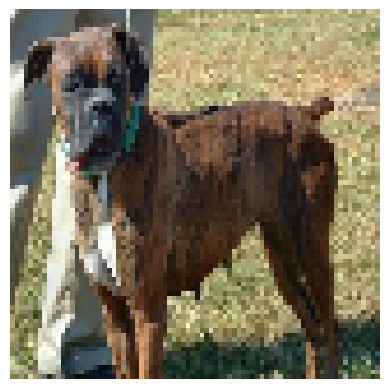

Label of the first image: 1


In [20]:
# 4

plt.imshow(X[0])
plt.axis('off')
plt.show()

print("Label of the first image:", labels[0])

0 is for Cat and 1 is for Dog

In [21]:
# 5
num_cats = np.sum(labels == 0)
num_dogs = np.sum(labels == 1)

print("Number of cats:", num_cats)
print("Number of dogs:", num_dogs)

Number of cats: 11658
Number of dogs: 11604


It is evenly distributed across the two target categories.

6. Batches of image data can be stored in two formats: NHWC, and NCHW. The meaning of the letters is:
  * *N*: number of images in batch
  * *H*: image height
  * *W*: image width
  * *C*: number of channels (3 for RGB images, 1 for grayscale images)
  
  Image data is in NHWC format if it has shape `(N, H, W, C)` and it is in NCHW format if it has shape `(N, C, H, W)`. Is `X` in NHWC format or NCHW format?

Given the shape of the X array as (23262, 80, 80, 3), it is in NHWC format.

7. Using scikit-learn's `train_test_split`, split `X` and `labels` into `X_train, X_test, labels_train, labels_test`, using 10% of the data as test data.

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, labels_train, labels_test = train_test_split(X, labels, test_size=0.1, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of labels_train:", labels_train.shape)
print("Shape of labels_test:", labels_test.shape)

Shape of X_train: (20935, 80, 80, 3)
Shape of X_test: (2327, 80, 80, 3)
Shape of labels_train: (20935,)
Shape of labels_test: (2327,)


8. We will create a basic CNN model to classify cats and dogs, using layers from `tensorflow.keras.layers`. Create a Sequential model `model` with the following layers:
  * `Rescaling(1/255, input_shape=...)`. This multiplies the value of each pixel by 1/255 so that it becomes a number between 0 and 1. Make sure to set `input_shape=` to equal the size of each image in `X`.
  * The following two layers, repeated three times: (i.e. `Conv2D` followed by `MaxPooling2D` followed by `Conv2D` etc.)
    * `Conv2D(64, 3, activation='relu')` (applies 64 convolutional filters, each of size `(3, 3)`, to the input)
    * `MaxPooling2D()` (by default pools over a `(2, 2)` window)
  * A `Flatten()` layer (flattens the last three dimensions into one so it can be input into the following Dense layers).
  * A `Dense(...)` layer with output size 64 and `relu` activation.
  * Another `Dense(...)` layer. The output of this layer will be our classification (dog vs cat). Use the output size and activation function which make sense for this classification problem.

  Finally examine the model with `model.input_shape`, `model.output_shape`, and `model.summary()`. Do the input and output shapes of the model make sense given the shapes of `X` and `labels`?

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

input_shape = X_train.shape[1:]

model = Sequential([
    Rescaling(1.0/255, input_shape=input_shape),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

print("Input shape:", model.input_shape)
print("Output shape:", model.output_shape)
model.summary()

Input shape: (None, 80, 80, 3)
Output shape: (None, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 80, 80, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 78, 78, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 39, 39, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 37, 37, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 18, 18, 64)        0         
 g2D)                                                            
                                                                 

9. Compile `model` with optimizer `'adam'`, loss function `'binary_crossentropy'` and `metrics='accuracy'`. Train the model using `model.fit(X_train, labels_train, validation_split=0.1, batch_size=16, epochs=...)` training for however many epochs is needed to improve validation accuracy. What is the best validation accuracy you achieve?

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, labels_train, validation_split=0.1, batch_size=16, epochs=10)

best_val_accuracy = max(history.history['val_accuracy'])
print("Best validation accuracy:", best_val_accuracy)

Epoch 1/10
1178/1178 [==============================] - 10s 7ms/step - loss: 0.6440 - accuracy: 0.6133 - val_loss: 0.5834 - val_accuracy: 0.6915
Epoch 2/10
1178/1178 [==============================] - 8s 7ms/step - loss: 0.5177 - accuracy: 0.7428 - val_loss: 0.5001 - val_accuracy: 0.7569
Epoch 3/10
1178/1178 [==============================] - 8s 7ms/step - loss: 0.4400 - accuracy: 0.7949 - val_loss: 0.4255 - val_accuracy: 0.7989
Epoch 4/10
1178/1178 [==============================] - 8s 7ms/step - loss: 0.3743 - accuracy: 0.8317 - val_loss: 0.3904 - val_accuracy: 0.8166
Epoch 5/10
1178/1178 [==============================] - 8s 6ms/step - loss: 0.3175 - accuracy: 0.8615 - val_loss: 0.3667 - val_accuracy: 0.8376
Epoch 6/10
1178/1178 [==============================] - 8s 7ms/step - loss: 0.2609 - accuracy: 0.8884 - val_loss: 0.3771 - val_accuracy: 0.8333
Epoch 7/10
1178/1178 [==============================] - 8s 7ms/step - loss: 0.2077 - accuracy: 0.9131 - val_loss: 0.4125 - val_accuracy


10. What is your final model's accuracy on the test set? (Hint: use `model.evaluate(...)`)

11. Display 5 images from the test set, your model's prediction for those images, and their confidence (probability scores for predicted class). (Hint: use `model.predict(...)`)

12. (BONUS) Modify the network by adding dropout. Add a Keras `Dropout` layer after each Max Pooling layer, using dropout probability 0.5. How does this affect training? (number of epochs needed and final model performance)

In [25]:
test_loss, test_accuracy = model.evaluate(X_test, labels_test)

print("Test accuracy:", test_accuracy)

73/73 [==============================] - 0s 4ms/step - loss: 0.6069 - accuracy: 0.8294
Test accuracy: 0.8293940424919128


1/1 [==============================] - 0s 72ms/step


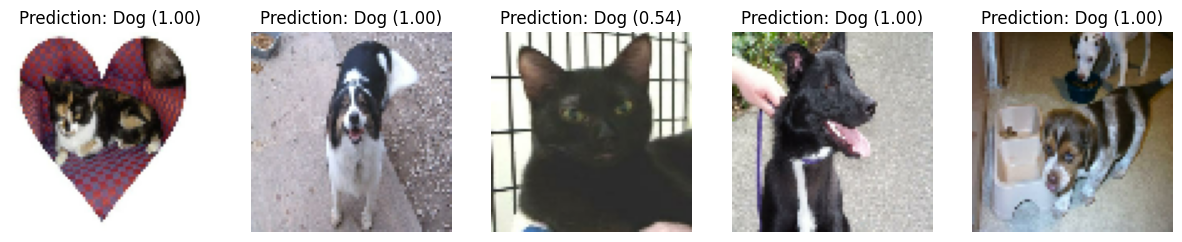

In [26]:

images_to_display = X_test[:5]

predictions = model.predict(images_to_display)
confidence_scores = [max(prediction) for prediction in predictions]

plt.figure(figsize=(15, 7))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images_to_display[i])
    plt.title("Prediction: {} ({:.2f})".format("Dog" if predictions[i] > 0.5 else "Cat", confidence_scores[i]))
    plt.axis('off')

plt.show()
